In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.datasets import mnist
from common import plot_multiclass_calibration_curve

In [3]:
def define():
    model = Sequential([
        Lambda(lambda x: x / 255.),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(.2),
        Dense(512, activation='relu'),
        Dropout(.2),
        Dense(10, activation='softmax')
    ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(opitimizer=optim, metrics=['accuracy'], loss=SparseCategoricalCrossentropy())
    return model

def train(x, y, model, epochs=10):
    model.fit(x, y, 
              batch_size=32,
              epochs=epochs,
              verbose=2)
    return model

def predict(model, x, samples=20):
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        probs: The expected value of our prediction
        entropy: The standard deviation of our prediction
    '''
    yhat_arr = []

    for t in range(samples):
        yhat = model(x, training=True)
        yhat_arr.append(yhat)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, entropy

In [4]:
data = mnist.load_data()
x_trn = data[0][0].astype(np.float32)
y_trn = data[0][1].astype(np.float32)
x_tst = data[1][0].astype(np.float32)
y_tst = data[1][1].astype(np.float32)
model = define()
model = train(x_trn, y_trn, model, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 - 6s - loss: 0.2229 - accuracy: 0.9350
Epoch 2/5
60000/60000 - 5s - loss: 0.1334 - accuracy: 0.9655
Epoch 3/5
60000/60000 - 5s - loss: 0.1207 - accuracy: 0.9722
Epoch 4/5
60000/60000 - 5s - loss: 0.1182 - accuracy: 0.9748
Epoch 5/5
60000/60000 - 5s - loss: 0.1134 - accuracy: 0.9775


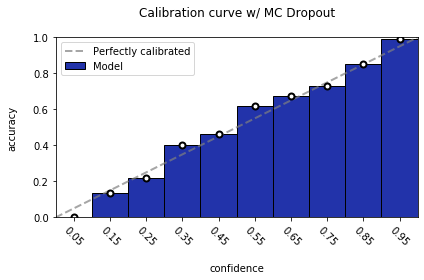

In [29]:
probs, entropy = predict(model, x_tst, samples=20)
_ = plot_multiclass_calibration_curve(probs, y_tst, bins=10, title='Calibration curve w/ MC Dropout')

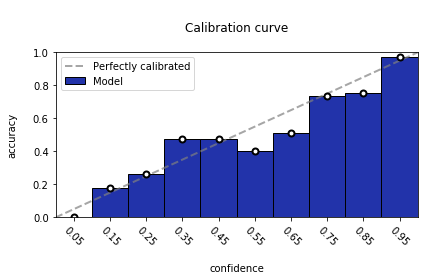

In [21]:
from common import multiclass_calibration_curve

def plot_multiclass_calibration_curve(probs, labels, bins=10, title=None):
    title = 'Reliability Diagram' if title is None else title
    midpoints, accuracies, mean_confidences = multiclass_calibration_curve(probs, labels, bins=bins)
    plt.bar(midpoints, accuracies, width=1.0/float(bins), align='center', lw=1, ec='#000000', fc='#2233aa', alpha=1, label='Model', zorder=0)
    plt.scatter(midpoints, accuracies, lw=2, ec='black', fc="#ffffff", zorder=2)
    plt.plot(np.linspace(0, 1.0, 20), np.linspace(0, 1.0, 20), '--', lw=2, alpha=.7, color='gray', label='Perfectly calibrated', zorder=1)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('\nconfidence')
    plt.ylabel('accuracy\n')
    plt.title('\n'+title+'\n')
    plt.xticks(midpoints, rotation=-45)
    plt.legend(loc='upper left')
    plt.tight_layout(h_pad=.5, w_pad=.5)

    return midpoints, accuracies, mean_confidences

probs = model(x_tst, training=False).numpy()
_ = plot_multiclass_calibration_curve(probs, y_tst, bins=10, title='Calibration curve')
plt.savefig('deterministic_classification.svg', bbox_inches='tight')